In this notebook, we'll analyze the variance of the UCI electricity demand dataset (see [here][0]). 

[0]:https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from zero_ts_demo.imports import *
from zero_ts_demo import helpers as hp
from zero_ts_demo import analyze_variance as av
from zero_ts_demo.load_data import load_model_data
from zero_ts_demo.helpers import create_image_grid
from zero_ts_demo import models as mod

# Load Data

We'll start by loading the model data:

In [3]:
MODEL_DATA = load_model_data()

In [4]:
df = MODEL_DATA.copy()
df.head(3)
# drop any columns that end in zero
df = df.drop(columns=df.columns[df.iloc[-1] == 0].tolist())

# Analyze Variance 

The variability of these data are not stationary. This can be easily seen by plotting the variance of one of the series:

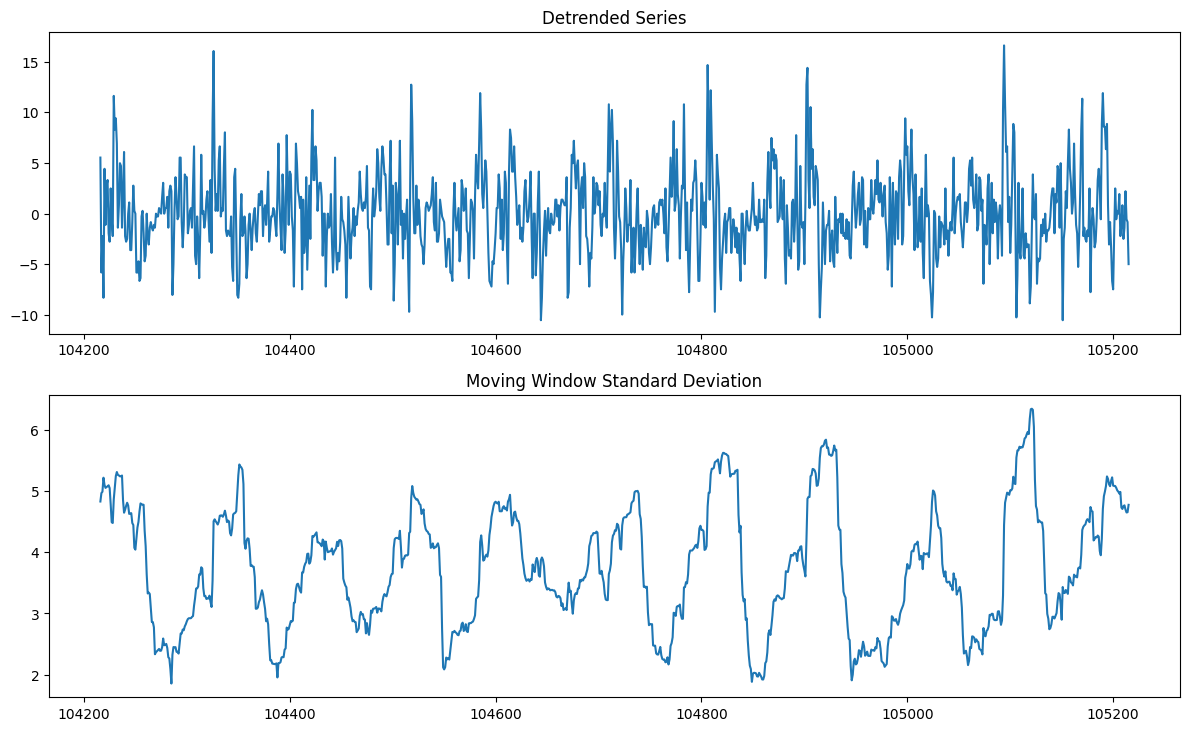

In [5]:
col = pd.Series(df.columns).sample(random_state=456048).iloc[0]
y = av.rolling_window_variance(df, col)
fig = av.plot(y)
fig

...the upper graph depicts the (detrended with simple moving average) time series, and the lower graph depicts the rolling-window 30-period moving average of standard deviation. Clearly, the standard deviation of these data is not static. 

Let's look at a larger sample of time series:

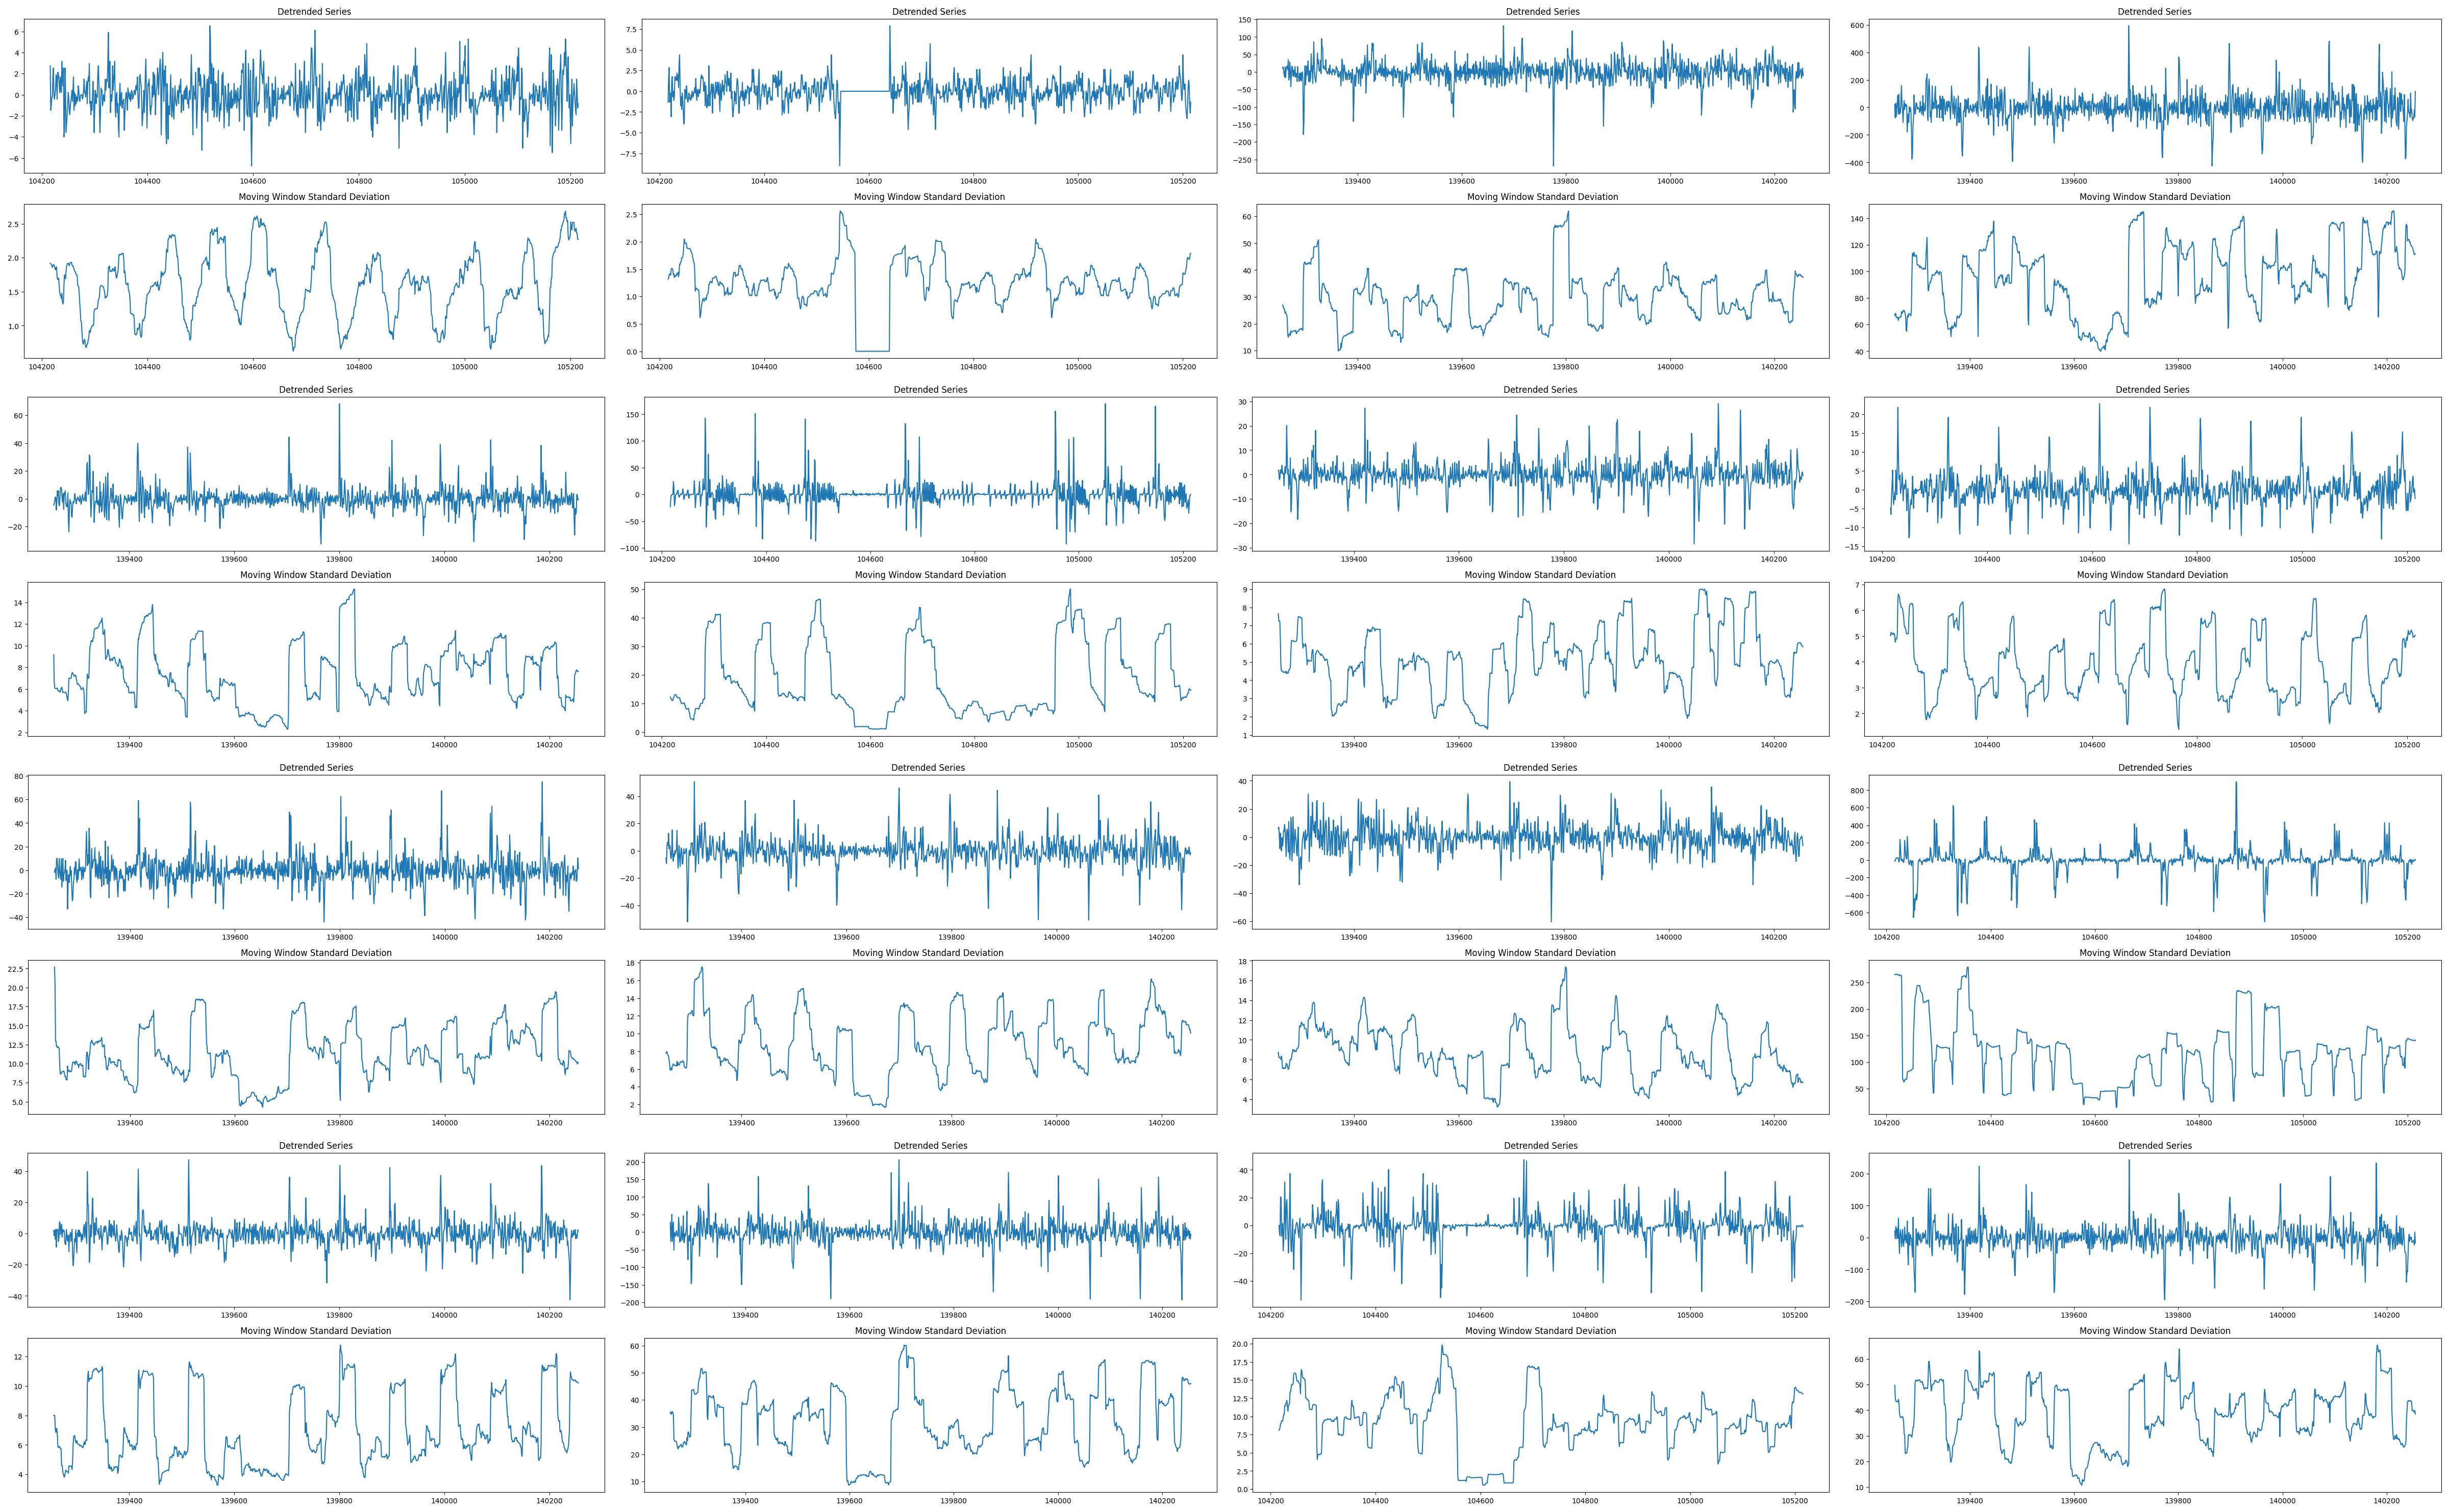

In [6]:
figs = list()
cols = pd.Series(df.columns).sample(16, random_state=486045).tolist()
for col in cols:
    y = av.rolling_window_variance(df, col)
    fig = av.plot(y)
    figs.append(fig)
fig = create_image_grid(figs, 4, 4, resize=1)
fig

The lm test verifies these mathematically:

In [7]:
from statsmodels.stats.diagnostic import het_arch
lm_tests = dict()

for col in df.columns:
    # prepare a training and test dataset for one of the time series in MODEL_DATA
    slr, sle = mod.train_test(MODEL_DATA.copy(), col, rolling=3, tail=0)
    
    # fit model, make a prediction and then plot 
    armodel = mod.StatsmodelsARModel(slr, sle, title='AR Model Test')
    armodel.fit_predict(dynamic=True)
    lm_tests[col] = het_arch(armodel.model.resid)[1] # p value
lm = pd.DataFrame.from_dict(lm_tests, orient='index')

In [12]:
x = lm[0]
n = x[x > 0.05].shape[0]
print(f"there are {n} series which have stationary variance. ")

there are 0 series which have stationary variance. 
